# Label pipeline
In this notebook, we try out the entire pipeline - from D + semantic data, through building a semantic map,
to raytracing the labels back to the camera position

In [1]:
import os
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
from yacs.config import CfgNode

from src.config import default_map_builder_cfg, default_sim_cfg
from src.features.mapping import SemanticMap3DBuilder
from src.model.perception import map_processing
from src.model.perception.labeler import LabelGenerator
from src.utils import category_mapping
from src.utils.category_mapping import get_instance_index_to_reseal_name_dict, get_reseal_index_to_color_vectorized, get_maskrcnn_index_to_reseal_index_dict
from src.utils.misc import get_semantic_map
from src.visualisation import instance_map_visualization
from src.visualisation.instance_map_visualization import visualize_2d_categorical_instance_map
from src.visualisation.semantic_map_visualization import (
    visualize_categorical_label_map,
    visualize_semantic_map,
)
from src.model.perception.model_wrapper import ModelWrapper

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if pathlib.PurePath(os.getcwd()).name == 'notebooks':
    print(pathlib.PurePath(os.getcwd()).name)
    os.chdir('..')

notebooks


In [3]:
TRAJECTORY = "00006-HkseAnWCgqk"
DEPTH_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/D"
RGB_IMAGE_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/RGB"
POSITIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/positions.npy"
ROTATIONS_FILE = f"./data/interim/trajectories/train/{TRAJECTORY}/rotations.npy"
SEMANTIC_MAP_DIR = f"./data/interim/trajectories/train/{TRAJECTORY}/Semantic"
trajectory_name = TRAJECTORY.split('-')[1]
SEMANTIC_INFO_FILE = f"./data/raw/train/scene_datasets/hm3d/train/{TRAJECTORY}/{trajectory_name}.semantic.txt"

In [4]:
scene_to_reseal_mapping = category_mapping.get_scene_index_to_reseal_index_vectorized(SEMANTIC_INFO_FILE)

Create map builder

In [5]:
sim_cfg = default_sim_cfg()
map_builder_cfg = default_map_builder_cfg()
map_builder_cfg.NUM_SEMANTIC_CLASSES = 6
map_builder_cfg.RESOLUTION = 0.05
map_builder_cfg.MAP_SIZE = [25, 1.5, 25]
map_builder_cfg.GET_ENTIRE_MAP = True
map_builder = SemanticMap3DBuilder(map_builder_cfg, sim_cfg)


[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.


Create model

In [6]:
model_config = CfgNode()
model_config.USE_INITIAL_TRANSFORMS = True
model_config.SCORE_THRESHOLD = 0.5
model_config.MASK_THRESHOLD = 0.5
model = ModelWrapper(model_config)
model.cuda()

Load poses, rgb images and depth images. Create semantic map, with RGB images as a placeholder for semantic labels

In [7]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from src.model.MaskRCNN import generating_semantic_masks
from torchvision.io import read_image
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()
model = maskrcnn_resnet50_fpn(weights=weights)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [7]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from src.model.MaskRCNN import generating_semantic_masks
from torchvision.io import read_image
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transform = weights.transforms()
model = maskrcnn_resnet50_fpn(weights=weights)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [7]:
rotations = np.load(ROTATIONS_FILE).view(dtype=np.quaternion)
positions = np.load(POSITIONS_FILE)
scene_index_to_category_index_map = category_mapping.get_scene_index_to_reseal_index_vectorized(SEMANTIC_INFO_FILE)

map_builder.clear()

def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image / 255



for i in tqdm(range(0,400)):
    depth_map = np.load(f"{DEPTH_MAP_DIR}/{i}.npy")
    rgb_image = load_image(f"{RGB_IMAGE_DIR}/{i}.png")
    map = model(rgb_image)
    #saved_semantics = np.load(f"{SEMANTIC_MAP_DIR}/{i}.npy")
    #map = get_semantic_map(saved_semantics, scene_index_to_category_index_map, map_builder_cfg.NUM_SEMANTIC_CLASSES)
    pose = (positions[i], rotations[i])
    map_builder.update_point_cloud(map, depth_map, pose, fast=True)
map_builder.concatenate_semantics()
print("Concatenating semantics done")
map_builder.update_kdtree()

100%|██████████| 400/400 [00:27<00:00, 14.45it/s]


Concatenating semantics done


In [24]:
point_cloud = np.asarray(map_builder.point_cloud.points)
point_cloud_semantic_labels = map_builder._point_cloud_semantic_labels

Get point cloud and visualize points with semantic information

In [27]:
plot_point_cloud = True

if plot_point_cloud:
    point_cloud = np.asarray(map_builder.point_cloud.points)
    point_cloud_semantic_labels = map_builder._point_cloud_semantic_labels

    color_converter = category_mapping.get_reseal_index_to_color_vectorized()

    point_cloud_categorical = np.argmax(point_cloud_semantic_labels, axis=-1) + (np.sum(
        point_cloud_semantic_labels, axis=-1
    ) > 0).astype(int)
    # Need to initialize this as a 3 channel image so we can use numpy indexing to assign the points that have a label
    # instead of having to loop over them
    point_cloud_rgb = np.dstack([point_cloud_categorical] * 3)[0]
    #point_cloud_rgb[point_cloud_categorical > 0] = color_converter(point_cloud_categorical[point_cloud_categorical > 0])

    point_cloud_o3d = o3d.utility.Vector3dVector(point_cloud[point_cloud_categorical > 0])
    pcd = o3d.geometry.PointCloud(point_cloud_o3d)
    colour = color_converter(point_cloud_categorical[point_cloud_categorical > 0])
    pcd.colors = o3d.utility.Vector3dVector(colour)
    o3d.visualization.draw_geometries([pcd])

: 

: 

Get 3D semantic map (i.e. Voxel grid) at an index and plot it

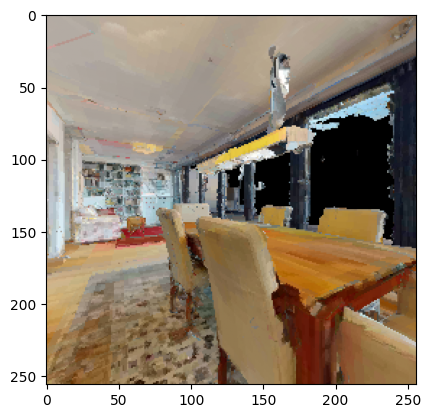

In [12]:
index = 321

rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{index}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255
plt.imshow(rgb_image)

In [13]:
pose = (positions[index], rotations[index])
semantic_map = map_builder.get_semantic_map_sparse(pose)

In [14]:
map_processor_cfg = CfgNode()
map_processor_cfg.NO_OBJECT_CONFIDENCE_THRESHOLD = 0.5
map_processor_cfg.HOLE_VOXEL_THRESHOLD = 2000
map_processor_cfg.OBJECT_VOXEL_THRESHOLD = 200
map_processor_cfg.DILATE = True

grid_index_of_origin = map_builder.get_grid_index_of_origin(pose[0])

label_generator = LabelGenerator(semantic_map, grid_index_of_origin, map_builder_cfg, map_processor_cfg, sim_cfg.SENSOR_CFG)


Use MapProcessor to build label map and instance map

In [15]:
plotter = visualize_categorical_label_map(label_generator.categorical_label_map, opacity=0.1)

plotter.show(jupyter_backend="panel")

VTKRenderWindowSynchronized(vtkXOpenGLRenderWindow, color_mappers=[LinearColorMapper(id='100...], sizing_mode='stretch_width')

In [15]:
plotter = instance_map_visualization.visualize_3d_categorical_instance_map(
    label_generator.categorical_instance_map, 
    label_generator.categorical_label_map, 
    0.1)

plotter.show(jupyter_backend="panel")

Raytrace in instance map and show results

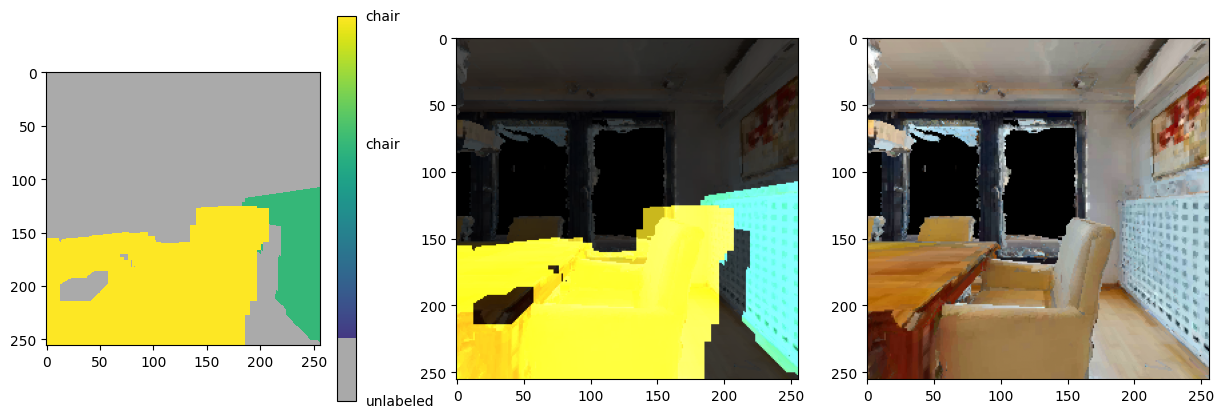

In [23]:
#index = 130
index = 320
pose = (positions[index], rotations[index])

instance_map_2d = label_generator.get_instance_map_2d(pose)
instance_label_to_reseal_name_dict = get_instance_index_to_reseal_name_dict(label_generator.categorical_instance_map, 
                                                                            label_generator.categorical_label_map)
rgb_image = cv2.imread(f"{RGB_IMAGE_DIR}/{index}.png")
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
rgb_image = rgb_image / 255

visualize_2d_categorical_instance_map(instance_map_2d, rgb_image, instance_label_to_reseal_name_dict)
plt.show()

In [28]:
label_dict = label_generator(pose)

In [29]:
model.train()
with torch.no_grad():
    loss = model(rgb_image, label_dict)

In [24]:
model.eval()
semantic_map_2d = model(rgb_image)

In [20]:
semantic_map_2d.sum(axis=(0,1))

array([5715.3406682,    0.       ,    0.       ,    0.       ,
          0.       ,    0.       ])

In [26]:
from src.model.perception.morphological_transformations import onehot_label_map_to_categorical_label_map
from src.model.perception.morphological_transformations import categorical_label_map_to_onehot_label_map
onehot_label_map = categorical_label_map_to_onehot_label_map(categorical_label_map, 7).astype(bool)
from scipy.ndimage.morphology import binary_dilation

for i in range(1, onehot_label_map.shape[-1]):
    print(i)
    onehot_label_map[..., i] = binary_dilation(onehot_label_map[..., i], iterations=1)
    onehot_label_map[onehot_label_map[..., i], 0] = 1
    
new_categorical_label_map = onehot_label_map_to_categorical_label_map(onehot_label_map)

/home/david/.local/lib/python3.7/site-packages/pyvista/jupyter/notebook.py:59: UserWarning: Failed to use notebook backend: 

Please install pythreejs to use this feature

Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


/home/david/.local/lib/python3.7/site-packages/pyvista/jupyter/notebook.py:59: UserWarning: Failed to use notebook backend: 

Please install pythreejs to use this feature

Falling back to a static output.
  f'Failed to use notebook backend: \n\n{e}\n\nFalling back to a static output.'


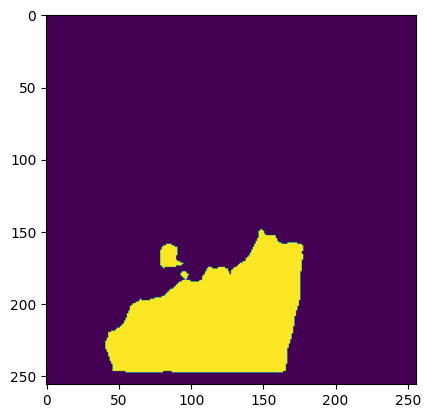

In [21]:
plt.imshow(semantic_map_2d.sum(axis=-1))

In [6]:
from src.model.perception.model_wrapper import ModelWrapper
model_config = CfgNode()
model_config.USE_INITIAL_TRANSFORMS = True
model_config.SCORE_THRESHOLD = 0.1
model_config.MASK_THRESHOLD = 0.5
model = ModelWrapper(model_config)
model.cuda()
semantic_map = model(rgb_image)[0]
